In [1]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
import math

In [2]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from livelossplot import PlotLosses

In [4]:
sigma_noise = 0.1
(x_data, y_data) = torch.load('foong_data.pt')

In [5]:
sigmoid = torch.nn.Sigmoid()
uniform = torch.distributions.Uniform(0, 1)

In [260]:
normal = torch.distributions.Normal(0, .1)

In [232]:
normal.sample()

tensor(-0.0098)

In [6]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [7]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [261]:
class ProbabilisticLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):#, q_weight_mu = None, q_weight_rho = None, q_bias_mu = None, q_bias_rho = None):
        super(ProbabilisticLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.q_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.q_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.weight_epsilon = torch.Tensor(out_features, in_features)
        self.bias_epsilon = torch.Tensor(out_features, in_features)
        
        self.weight_sample = torch.Tensor(out_features, in_features)
        self.bias_sample = torch.Tensor(out_features, in_features)
        
        self.reset_parameters()
        
        mu = torch.tensor(0.0)
        rho = sigma_to_rho(torch.tensor(1.0))
        
        self.prior_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.prior_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.prior_weight_mu.requires_grad = False
        self.prior_weight_rho.requires_grad = False
        self.prior_bias_mu.requires_grad = False
        self.prior_bias_rho.requires_grad = False
        
        nn.init.constant_(self.prior_weight_mu, mu)
        nn.init.constant_(self.prior_weight_rho, rho)
        nn.init.constant_(self.prior_bias_mu, mu)
        nn.init.constant_(self.prior_bias_rho, rho)
        
    def generate_rand(self):
        self.weight_epsilon = torch.randn(size=self.q_weight_mu.size())
        self.bias_epsilon = torch.randn(size=self.q_bias_mu.size())
        return (self.weight_epsilon, self.bias_epsilon)
    
    def reparameterization(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        self.weight_sample = self.weight_epsilon.mul(sigma_weight).add(self.q_weight_mu)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        self.bias_sample = self.bias_epsilon.mul(sigma_bias).add(self.q_bias_mu)
        return (self.weight_sample, self.bias_sample)

    def q_log_pdf(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        nw = torch.distributions.Normal(self.q_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        nb = torch.distributions.Normal(self.q_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def prior_log_pdf(self):
        sigma_weight = rho_to_sigma(self.prior_weight_rho)
        nw = torch.distributions.Normal(self.prior_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.prior_bias_rho)
        nb = torch.distributions.Normal(self.prior_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def lock_means(self):
        self.q_weight_mu.requires_grad = False
        self.q_bias_mu.requires_grad = False
        
    def lock_rhos(self):
        self.q_weight_rho.requires_grad = False
        self.q_bias_rho.requires_grad = False
        
    def unlock_means(self):
        self.q_weight_mu.requires_grad = True
        self.q_bias_mu.requires_grad = True
        
    def unlock_rhos(self):
        self.q_weight_rho.requires_grad = True
        self.q_bias_rho.requires_grad = True
        
    def set_hyper_parameters(self, w_mu, w_rho, b_mu, b_rho):
        self.q_weight_mu.data = w_mu.data
        self.q_weight_rho.data = w_rho.data
        self.q_bias_mu.data = b_mu.data
        self.q_bias_rho.data = b_rho.data
    
    def set_sampled_parameters(self, weight_sample, bias_sample):
        self.weight_sample = weight_sample
        self.bias_sample = bias_sample
    
    def reset_parameters(self):
        torch.nn.init.normal_(self.q_weight_mu, mean=0.0, std=3.0)
        torch.nn.init.constant_(self.q_weight_rho, -5.0)
        torch.nn.init.normal_(self.q_bias_mu, mean=0.0, std=3.0)
        torch.nn.init.constant_(self.q_bias_rho, -5.0)
       
    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight_sample, bias=self.bias_sample)

In [262]:
class RegressionModel(nn.Module):
    def __init__(self, H, mu_init = None, sigma_init = None):
        super(RegressionModel, self).__init__()
        
        self.linear1 = ProbabilisticLinear(1, H)
        self.linear2 = ProbabilisticLinear(H,1)
        
        self.registered_layers = []
        self.registered_layers.append(self.linear1)
        self.registered_layers.append(self.linear2)
        
        
        self.nb_parameters = self.count_parameters()
        
    def forward(self, x):
        out = x;
        for k in range(len(self.registered_layers)-1):
            out = torch.tanh(self.registered_layers[k](out))
        out = self.registered_layers[-1](out)
        return out
    
    def resample_parameters(self):
        w_samples = []
        b_samples = []
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].generate_rand()
            self.registered_layers[k].reparameterization()
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def lock_means(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].lock_means()
        
    def lock_rhos(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].lock_rhos()
        
    def unlock_means(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].unlock_means()
        
    def unlock_rhos(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].unlock_rhos()
            
    def set_hyper_parameters(self, w_mus, w_rhos, b_mus, b_rhos):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].set_hyper_parameters(w_mus[k], w_rhos[k], b_mus[k], b_rhos[k])
    
    def set_sampled_parameters(self, weight_samples, bias_samples):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].set_sampled_parameters(weight_samples[k], bias_samples[k])
    
    def q_log_pdf(self):
        list_LQ = []
        for k in range(len(self.registered_layers)):
            list_LQ.append(self.registered_layers[k].q_log_pdf())
        stack_LQ = torch.stack(list_LQ)
        return torch.sum(stack_LQ)
    
    def prior_log_pdf(self):
        list_LP = []
        for k in range(len(self.registered_layers)):
            list_LP.append(self.registered_layers[k].prior_log_pdf())
        stack_LP = torch.stack(list_LP)
        return torch.sum(stack_LP)
        
    def compute_elbo(self, x_data, y_data, sample_size):
        L = []
        for _ in range(sample_size):
            self.resample_parameters()

            LQ = self.q_log_pdf() 
            LP = self.prior_log_pdf() 

            y_pred = self.forward(x_data)
            LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()

            L.append(LQ - LP - LL)
        L = torch.stack(L)
        L = torch.mean(L)
        return L

In [263]:
def L2(tensor):
    return (tensor*tensor).sum().sqrt()
L2_vect = np.vectorize(L2)

In [264]:
def distance_matrix(list_of_tensors):
    m = len(list_of_tensors)
    D = torch.diag(L2_vec(list_of_tensors))
    for i in range(m):
        for j in range(i+1, m):
            

SyntaxError: unexpected EOF while parsing (<ipython-input-264-c4a2ff80b2fa>, line 6)

In [363]:
a = torch.stack([torch.tensor(np.inf), torch.tensor(12.)])

In [365]:
sorted(a)

[tensor(12.), tensor(inf)]

In [322]:
sorted(list(range(10)), reverse = True)[1:]

[8, 7, 6, 5, 4, 3, 2, 1, 0]

In [395]:
class BoostingModel(nn.Module):
    
    def __init__(self, H, nComponents, tolerance):
        super(BoostingModel, self).__init__()
        
        self.H = H
        self.fixed_components = []
        self.fixed_mixture_probas = torch.tensor([1.])
        self.learnable_proba = None
        self.learnable_component = RegressionModel(H)
        self.nComponents = nComponents
        self.current_nComponents = 1
        self.current_component = self.learnable_component
        self.current_component_index = None
        self.current_hyper_parameters = {'weight_mus': [layer.q_weight_mu for layer in self.current_component.registered_layers],
                                   'weight_rhos': [layer.q_weight_rho for layer in self.current_component.registered_layers],
                                   'bias_mus' : [layer.q_bias_mu for layer in self.current_component.registered_layers],
                                   'bias_rhos': [layer.q_bias_rho for layer in self.current_component.registered_layers]}
        
        self.current_sampled_parameters = {'weight': [layer.weight_sample for layer in self.current_component.registered_layers],
                                          'bias': [layer.bias_sample for layer in self.current_component.registered_layers]}
        
        self.tolerance = tolerance
        self.potential_starting_points = [(0, torch.tensor(np.inf)) for i in range(self.tolerance)]
    def refresh_current_hyper_parameters(self):
        self.current_hyper_parameters = {'weight_mus': [layer.q_weight_mu for layer in self.current_component.registered_layers],
                                   'weight_rhos': [layer.q_weight_rho for layer in self.current_component.registered_layers],
                                   'bias_mus' : [layer.q_bias_mu for layer in self.current_component.registered_layers],
                                   'bias_rhos': [layer.q_bias_rho for layer in self.current_component.registered_layers]}
    
    def refresh_current_sampled_parameters(self):
        self.current_sampled_parameters = {'weight': [layer.weight_sample for layer in self.current_component.registered_layers],
                                          'bias': [layer.bias_sample for layer in self.current_component.registered_layers]}
    
    def forward(self, x):
        out = self.current_component(x)
        return out
    
    def resample_parameters_in_eval(self):
        self.sample_component(last = True)
        self.sample_parameters()
        self.refresh_current_sampled_parameters()
        
    def resample_parameters_in_train(self):
        self.sample_component(last = False)
        self.sample_parameters()
        self.refresh_current_sampled_parameters()
    
    def sample_component(self, last = False):
        
        if len(self.fixed_components) == 0:
            self.current_component = self.current_component
        
        elif not last:
            self.current_component = np.random.choice(self.fixed_components, p = self.fixed_mixture_probas.data.numpy())
        else:
            pi = sigmoid(self.learnable_proba.detach())
            if uniform.sample()< pi:
                self.current_component = self.learnable_component
            else:
                self.sample_component(last = False)
                
    def sample_parameters(self):
        self.current_component.resample_parameters()
        
    def mixture_log_pdf(self):
        pi = sigmoid(self.learnable_proba)
        probs = torch.cat((self.fixed_mixture_probas*(1-pi), pi.unsqueeze(0)))
        #print(probs)
        log_q = []
        for i, component in enumerate(self.fixed_components):
            #component.set_sampled_parameters(self.current_parameters['weight_mus'],
                                     #self.current_parameters['weight_rhos'],
                                     #self.current_parameters['bias_mus'],
                                     #self.current_parameters['bias_rhos'])
            component.set_sampled_parameters(self.current_sampled_parameters['weight'],
                                            self.current_sampled_parameters['bias'])
            log_q.append(component.q_log_pdf())
        #self.learnable_component.set_parameters(self.current_parameters['weight_mus'],
                                     #self.current_parameters['weight_rhos'],
                                     #self.current_parameters['bias_mus'],
                                     #self.current_parameters['bias_rhos'])
        self.learnable_component.set_sampled_parameters(self.current_sampled_parameters['weight'],
                                                       self.current_sampled_parameters['bias'])
        log_q.append(self.learnable_component.q_log_pdf())
        log_q = torch.stack(log_q)
        #signs = log_q.detach().sign()
        log_q = log_q.add(torch.log(probs))
        log_q = torch.logsumexp(log_q, dim = 0)
        """investigate gradient of max"""
        #maximum = log_q.max()
        #log_q = log_q - maximum
        #log_q = torch.exp(log_q)
        #log_q = log_q*probs
        #log_q = torch.log(torch.sum(log_q)) + maximum
        return(log_q)
    
    def compute_mixture_elbo(self, x_data, y_data, sample_size):
        if type(self.learnable_proba) != type(None):
            #print("1")
            
            pi_new = sigmoid(self.learnable_proba)
            
        
            """Compute expectancy w.r.t old mixture"""
            L_old_mixture = []
            for _ in range(sample_size):
                self.resample_parameters_in_train()
                LQ = self.mixture_log_pdf()
             #   print(LQ.grad_fn)
                y_pred = self.forward(x_data)
                LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()
                LP = self.current_component.prior_log_pdf()
                L_old_mixture.append(LQ - LL - LP)
            L_old_mixture = torch.stack(L_old_mixture)
            #print(L_old_mixture.grad_fn)
            L_old_mixture = torch.mean(L_old_mixture)
            #print(L_old_mixture < self.potential_starting_points[-1][1])
            if L_old_mixture < self.potential_starting_points[-1][1]:
                self.potential_starting_points[-1] = (self.current_sampled_parameters, L_old_mixture.detach().data)
                self.potential_starting_points = sorted(self.potential_starting_points, key = lambda x: x[1])
            
            #print(L_old_mixture.grad_fn)
            #print(L_old_mixture)

            """Compute expectancy w.r.t new component"""
            L_new_component = []
            for _ in range(sample_size):
                self.current_component = self.learnable_component
                self.sample_parameters()
                self.refresh_current_sampled_parameters()
                LQ = self.mixture_log_pdf()
                self.sample_component(last = True)
                y_pred = self.forward(x_data)
                LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()
                LP = self.current_component.prior_log_pdf()
                L_new_component.append(LQ - LL - LP)
            L_new_component = torch.stack(L_new_component)
            L_new_component = torch.mean(L_new_component)
            #print(L_new_component.grad_fn)
            L = (1-pi_new)*L_old_mixture + pi_new*L_new_component
            #
            return L
        else:
            #print("2")
            L = self.learnable_component.compute_elbo(x_data, y_data, sample_size)
            #print(L)
            if L.detach() < self.potential_starting_points[-1][1]:
                self.potential_starting_points[-1] = (self.current_sampled_parameters, L.detach().data)
                self.potential_starting_points = sorted(self.potential_starting_points, key = lambda x: x[1])
                #print(self.potential_starting_points)
                #self.potential_starting_points = self.potential_starting_points[1:]
            return(L)
    
    
    def new_component(self, losses, epsilon, new_pi):
        #print('std losses',torch.std(losses))
        
        if epsilon and len(self.fixed_components)+1<self.nComponents:
        #if torch.std(losses) < epsilon and len(self.components)<self.nComponents:
            self.refresh_current_hyper_parameters()
            print("WE GOT THERE !!!!")
            self.learnable_component.lock_means()
            self.learnable_component.lock_rhos()
            self.fixed_components.append(self.learnable_component)
            self.current_component = self.learnable_component
            self.refresh_current_hyper_parameters()
            self.learnable_component = RegressionModel(self.H)
            self.learnable_component.set_hyper_parameters(torch.mean(torch.stack([c[0]['weight'] for c in self.potential_starting_points])),
                                     torch.tensor(,
                                     torch.mean(torch.stack([c[0]['bias_mus'] for c in self.potential_starting_points])),
                                     torch.mean(torch.stack([c[0]['bias_rhos'] for c in self.potential_starting_points])))
            #self.learnable_component.lock_means()
            #self.learnable_component.lock_rhos()
            if type(self.learnable_proba) != type(None):
                self.learnable_proba.detach_()
                pi = sigmoid(self.learnable_proba)
                self.fixed_mixture_probas = torch.cat((self.fixed_mixture_probas*(1 - pi), pi.unsqueeze(0)))
            self.learnable_proba = torch.tensor(float(new_pi), requires_grad = True)
            print('NEW COMPONENT OK')
            return 1
#torch.std(losses) < epsilon
        else:
            return 0

In [404]:
[c[0]['weight'] for c in model.potential_starting_points]

[[tensor([[ 3.6424e-09],
          [ 4.5574e-41],
          [-9.4051e-20],
          [ 3.0935e-41],
          [        nan],
          [ 3.9105e+00],
          [ 4.1723e-08],
          [ 3.7668e+00],
          [-1.5293e-19],
          [ 3.0935e-41],
          [ 1.1351e-43],
          [ 0.0000e+00],
          [-5.3698e-20],
          [ 3.0935e-41],
          [-2.5800e-20],
          [ 3.0935e-41],
          [-1.5293e-19],
          [ 3.0935e-41],
          [-1.5293e-19],
          [ 3.0935e-41],
          [ 1.4013e-45],
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          [ 1.7937e-43],
          [ 0.0000e+00],
          [ 8.9683e-44],
          [ 0.0000e+00],
          [-6.5032e-19],
          [ 3.0935e-41],
          [ 2.2421e-44],
          [ 0.0000e+00],
          [ 9.8584e-11],
          [ 3.8529e+00],
          [-1.5882e-23],
          [ 3.7906e+00],


In [394]:
model.potential_starting_points[0][0]

{'weight': [tensor([[-6.6954e-19],
          [ 3.0935e-41],
          [-1.8854e-19],
          [ 3.0935e-41],
          [ 4.4842e-44],
          [ 4.4842e-44],
          [ 4.4842e-44],
          [ 4.4842e-44],
          [ 1.6115e-43],
          [ 1.4153e-43],
          [ 1.5134e-43],
          [ 1.4293e-43],
          [ 6.4460e-44],
          [ 1.5695e-43],
          [ 1.5554e-43],
          [ 1.6255e-43],
          [ 1.4153e-43],
          [ 1.5414e-43],
          [ 1.6255e-43],
          [ 1.4714e-43],
          [ 1.3593e-43],
          [ 1.5134e-43],
          [ 1.3312e-43],
          [ 1.6115e-43],
          [ 1.6255e-43],
          [ 1.3593e-43],
          [ 1.5975e-43],
          [ 1.6255e-43],
          [ 1.4714e-43],
          [ 1.5414e-43],
          [ 1.4433e-43],
          [ 1.3312e-43],
          [ 1.5695e-43],
          [ 1.5554e-43],
          [ 1.4714e-43],
          [ 1.5414e-43],
          [ 1.6255e-43],
          [ 1.6115e-43],
          [ 4.4842e-44],
          [ 8.5

In [378]:
"""
- Underfit the first component
- Initialize with prefitted new components
"""

'\n- Underfit the first component\n- Initialize with prefitted new components\n'

In [396]:
model = BoostingModel(50, 10, 10)

In [380]:
model.potential_starting_points

[(0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf)),
 (0, tensor(inf))]

In [397]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.95,verbose=True)
optimizer.zero_grad()

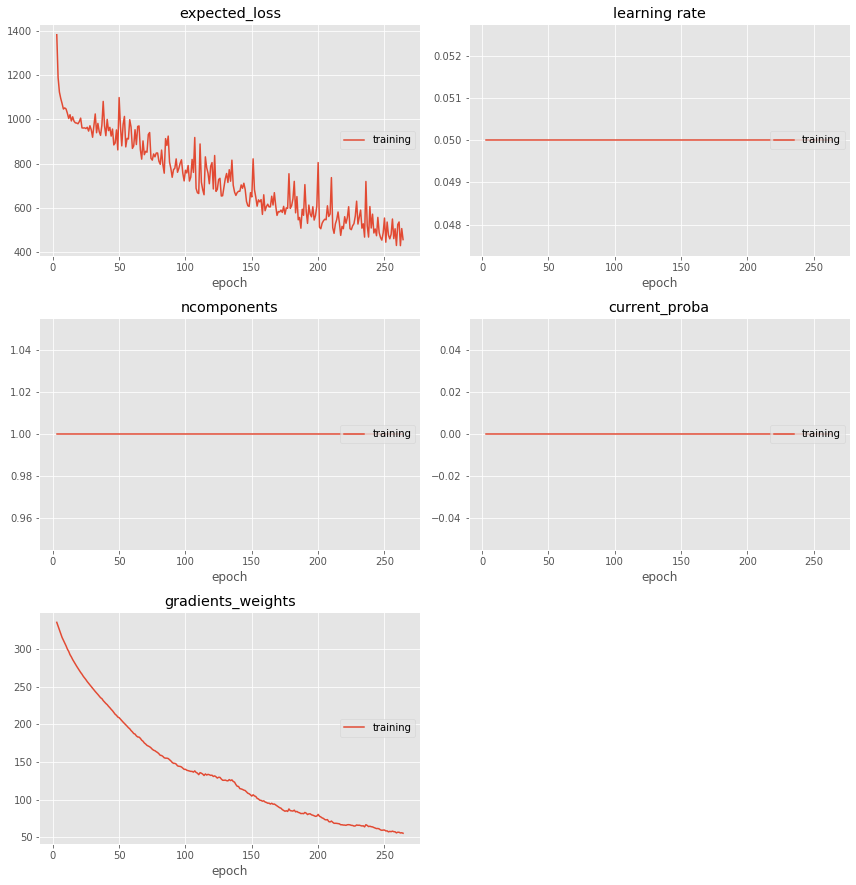

expected_loss:
training   (min:  429.571, max: 268799.031, cur:  456.928)

learning rate:
training   (min:    0.050, max:    0.050, cur:    0.050)

ncomponents:
training   (min:    1.000, max:    1.000, cur:    1.000)

current_proba:
training   (min:    0.000, max:    0.000, cur:    0.000)

gradients_weights:
training   (min:   55.316, max:  349.744, cur:   55.316)
WE GOT THERE !!!!


KeyError: 'weight_mus'

In [398]:
%matplotlib inline
num_epoch = 300
num_iterations = 100
liveloss = PlotLosses()

#M = int(.005/learning_rate)+1
weights = []
M=5
j = 0
std_steps = 100
stop = False
while stop == False:
#for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        #if new_comp_this_epoch:
            #print('before grad', model.learnable_proba)
        loss = model.compute_mixture_elbo(x_data, y_data, M)
        losses[k] = loss.detach()
        loss.backward()
        #if new_comp_this_epoch:
        #    print('after grad', model.current_proba_parameter)
        #print(model.components[0].linear1.weight_sample.grad)
        gradients = torch.sum(model.learnable_component.linear1.q_weight_mu.detach()**2)
        weights.append(gradients)
        
        optimizer.step()
        model.refresh_current_hyper_parameters()
        #print(model.current_proba_parameter)
    if j>std_steps and model.current_nComponents < model.nComponents:
#        new_comp = model.new_component(None, epsilon = (optimizer.param_groups[0]['lr'] != learning_rate), new_pi = np.log(1./(4*model.nComponents+3)))
        new_comp = model.new_component(None, epsilon = (torch.std(torch.stack(weights[-std_steps:])) < .1), new_pi = 0.)#np.log(1./(4*model.nComponents+3)))

        #print('STOP', stop)
        if new_comp:
            model.current_nComponents += 1
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
            optimizer.add_param_group({"params": model.learnable_proba, 'lr': .005})
            #break
            #M+=10
    #if model.nComponents ==3 and (optimizer.param_groups[0]['lr'] != learning_rate):
    #    model.learnable_component.lock_means()
    #    model.learnable_component.lock_rhos()
    #    model.fixed_components.append(model.learnable_component)
    #    pi = model.learnable_proba.detach()
    #    model.fixed_mixture_probas = torch.cat(((1-pi)*model.fixed_mixture_probas, pi.unsqueeze(0)))
    #    break

        #print(model.current_proba_parameter)
    #print(model.mixture_probas)
    #print(torch.std(torch.stack(losses[k-4:k])))
    def f(x):
        if type(x) == type(None):
            return(0.)
        else:
            return(sigmoid(x))
    #f = lambda x: {type(None): 1}.get(type(x), sigmoid(x))
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    logs['ncomponents'] = len(model.fixed_components) + 1
    logs['current_proba'] = f(model.learnable_proba)
    logs['gradients_weights'] = gradients
    #iilogs['proba_gradients'] = prob_grad
    #if type(model.current_proba_parameter) != type(None):
    #    logs['current_proba'] = model.current_proba_parameter.detach().data
    lr = optimizer.param_groups[0]['lr']
    #M = int(.005/lr)+1
    #M=5
    #print(M)
    liveloss.update(logs)
    liveloss.draw()
    if j > std_steps:
         weights = weights[-std_steps:]
    #print('epoch', j, 'num_components', len(model.components), 'stop', stop)
    
    scheduler.step(logs['expected_loss'])
    j+=1
    
    

In [399]:
model.potential_starting_points

[({'weight': [tensor([[ 3.6424e-09],
            [ 4.5574e-41],
            [-9.4051e-20],
            [ 3.0935e-41],
            [        nan],
            [ 3.9105e+00],
            [ 4.1723e-08],
            [ 3.7668e+00],
            [-1.5293e-19],
            [ 3.0935e-41],
            [ 1.1351e-43],
            [ 0.0000e+00],
            [-5.3698e-20],
            [ 3.0935e-41],
            [-2.5800e-20],
            [ 3.0935e-41],
            [-1.5293e-19],
            [ 3.0935e-41],
            [-1.5293e-19],
            [ 3.0935e-41],
            [ 1.4013e-45],
            [ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            [ 1.7937e-43],
            [ 0.0000e+00],
            [ 8.9683e-44],
            [ 0.0000e+00],
            [-6.5032e-19],
            [ 3.0935e-41],
            [ 2.2421e-44],
            [ 0.0000e+00],
            [ 9.85

In [306]:
L = [torch.zeros(1) for _ in range (10)]

In [309]:
torch.std(torch.stack(L))

tensor(0.)

In [295]:
gradients.numpy()

array(340.44202, dtype=float32)

In [287]:
logs

{}

In [208]:
model.nComponents

3

In [69]:
L = list(model.parameters())

In [188]:
loss = model.compute_mixture_elbo(x_data, y_data, M)

In [189]:
loss

tensor(5587.8184, grad_fn=<AddBackward0>)

In [186]:
model.mixture_log_pdf()

tensor(-959440.3750, grad_fn=<LogsumexpBackward>)

In [190]:
model.learnable_component.linear1.q_weight_mu

Parameter containing:
tensor([[1.9122],
        [0.5026],
        [0.5593]], requires_grad=True)

In [120]:
model.learnable_component

RegressionModel(
  (linear1): ProbabilisticLinear()
  (linear2): ProbabilisticLinear()
)

In [90]:
model.fixed_components

[RegressionModel(
   (linear1): ProbabilisticLinear()
   (linear2): ProbabilisticLinear()
 )]

In [160]:
model.current_hyper_parameters

{'weight_mus': [Parameter containing:
  tensor([[ 1.0265],
          [-3.1785],
          [-3.4606]]), Parameter containing:
  tensor([[ 3.0474,  2.2506, -1.0039]])], 'weight_rhos': [Parameter containing:
  tensor([[-5.3336],
          [-3.3456],
          [-4.0991]]), Parameter containing:
  tensor([[-4.5345, -4.8848, -4.7102]])], 'bias_mus': [Parameter containing:
  tensor([0.3592, 0.7081, 3.2197]), Parameter containing:
  tensor([-0.6046])], 'bias_rhos': [Parameter containing:
  tensor([-5.6241, -3.8920, -4.3011]), Parameter containing:
  tensor([-4.8722])]}

In [161]:
model.fixed_components[0].linear1.q_weight_mu

Parameter containing:
tensor([[ 1.0265],
        [-3.1785],
        [-3.4606]])

In [135]:
def mixture_log_pdf(self):
        pi = sigmoid(self.learnable_proba)
        probs = torch.cat((self.fixed_mixture_probas*(1-pi), pi.unsqueeze(0)))
        log_q = []
        for i, component in enumerate(self.fixed_components):
            component.set_parameters(self.current_parameters['weight'], self.current_parameters['bias'])
            log_q.append(component.q_log_pdf())
        self.learnable_component.set_parameters(self.current_parameters['weight'], self.current_parameters['bias'])
        log_q.append(self.learnable_component.q_log_pdf())
        log_q = torch.stack(log_q)
        signs = log_q.detach().sign()
        log_q = log_q + torch.log(probs)
        log_q = torch.logsumexp(log_q, dim = 0)
        """investigate gradient of max"""
        #maximum = log_q.max()
        #log_q = log_q - maximum
        #log_q = torch.exp(log_q)
        #log_q = log_q*probs
        #log_q = torch.log(torch.sum(log_q)) + maximum
        return(log_q)
    
    def compute_mixture_elbo(self, x_data, y_data, sample_size):
        if type(self.learnable_proba) != type(None):
            #print("1")
            
            pi_new = sigmoid(self.learnable_proba)
            
        
            """Compute expectancy w.r.t old mixture"""
            L_old_mixture = []
            for _ in range(sample_size):
                self.resample_parameters_in_train()
                LQ = self.mixture_log_pdf()
                y_pred = self.forward(x_data)
                LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()
                LP = self.current_component.prior_log_pdf()
                L_old_mixture.append(LQ - LL - LP)
            L_old_mixture = torch.stack(L_old_mixture)
            L_old_mixture = torch.mean(L_old_mixture)
            #print(L_old_mixture)

            """Compute expectancy w.r.t new component"""
            L_new_component = []
            for _ in range(sample_size):
                self.current_component = self.learnable_component
                self.sample_parameters()
                self.refresh_current_parameters()
                LQ = self.mixture_log_pdf()
                self.sample_component(last = True)
                y_pred = self.forward(x_data)
                LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()
                LP = self.current_component.prior_log_pdf()
                L_new_component.append(LQ - LL - LP)
            L_new_component = torch.stack(L_new_component)
            L_new_component = torch.mean(L_new_component)
            #print(L_new_component)
            L = (1 - pi_new)*L_old_mixture + pi_new*L_new_component
            return L
        else:
            #print("2")
            return(self.learnable_component.compute_elbo(x_data, y_data, sample_size))

tensor([[-0.7464],
        [ 2.8754],
        [-1.7495],
        [ 3.3453],
        [ 2.8336],
        [ 2.8256],
        [ 1.6813],
        [ 0.9059],
        [-2.4120],
        [ 3.0687],
        [ 5.4838],
        [ 4.2517],
        [ 0.6590],
        [-2.0982],
        [-1.1971],
        [-4.6457],
        [-3.0917],
        [-1.8628],
        [-4.6245],
        [-4.6760],
        [ 2.9383],
        [-1.1491],
        [ 1.1644],
        [ 0.6120],
        [-1.1772],
        [ 1.8544],
        [ 5.0424],
        [-9.7455],
        [-1.1111],
        [-0.1163],
        [ 1.4870],
        [ 3.8894],
        [-8.1245],
        [-3.2038],
        [ 1.4818],
        [-6.5414],
        [-3.6143],
        [ 2.9011],
        [-0.1090],
        [ 2.1384],
        [-5.0128],
        [ 6.9370],
        [-1.6527],
        [ 0.5770],
        [-5.8995],
        [-0.6790],
        [-3.5299],
        [ 1.2216],
        [ 0.1846],
        [-0.2513]])

In [228]:
model = RegressionModel(50)

In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

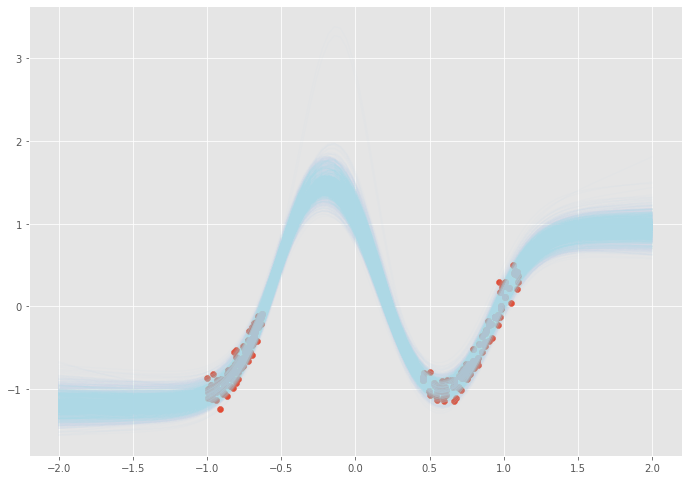

In [316]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    model.resample_parameters_in_eval()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [317]:
model.fixed_mixture_probas

tensor([2.3207e-04, 1.1833e-02, 7.8272e-03, 9.5646e-03, 2.8236e-02, 5.4515e-02,
        1.4309e-01, 2.4507e-01, 4.9963e-01])

In [319]:
sigmoid(model.learnable_proba)

tensor(0.0946, grad_fn=<SigmoidBackward>)

In [228]:
model.fixed_mixture_probas

tensor([0.9837, 0.0163])

In [230]:
sigmoid(model.learnable_proba)

tensor(0.0042, grad_fn=<SigmoidBackward>)

AttributeError: 'BoostingModel' object has no attribute 'resample_parameters'

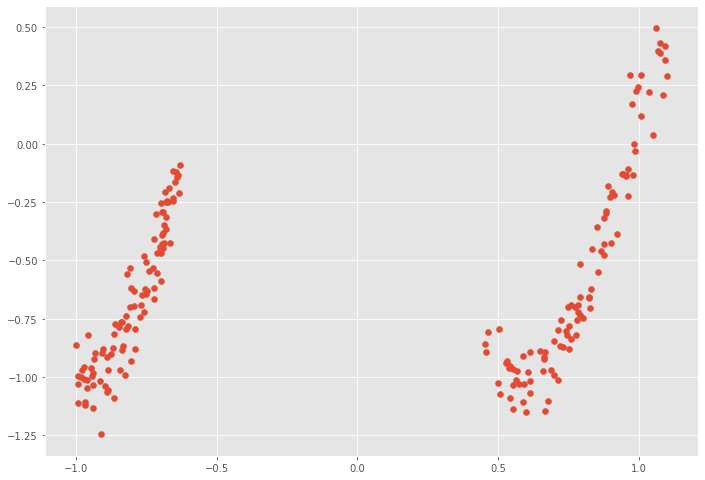

In [57]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    model.resample_parameters()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [139]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cortax/Anaconda3/Library/bin/graphviz/'

In [140]:
#make_dot(model(x_data), params=dict(model.named_parameters()))

In [234]:
model = RegressionModel(50)

In [235]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.95,verbose=True)
optimizer.zero_grad()

In [64]:
model.mixture_probas.numel()

1

KeyboardInterrupt: 

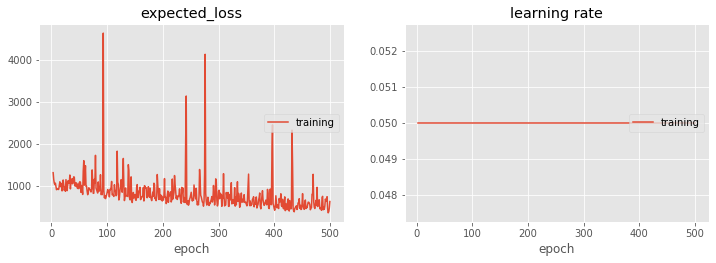

In [236]:
%matplotlib inline
num_epoch = 1000
num_iterations = 100
liveloss = PlotLosses()

M = int(.005/learning_rate)+1
for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        loss = model.compute_elbo(x_data, y_data, M)
        losses[k] = loss
        loss.backward()
        #print(model.linear1.weight_sample.grad)
        optimizer.step()
    
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    lr = optimizer.param_groups[0]['lr']
    M = int(.005/lr)+1
    print(M)
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['expected_loss'])
    

In [18]:
model.requires_grad_(False)

RegressionModel(
  (linear1): ProbabilisticLinear()
  (linear2): ProbabilisticLinear()
)

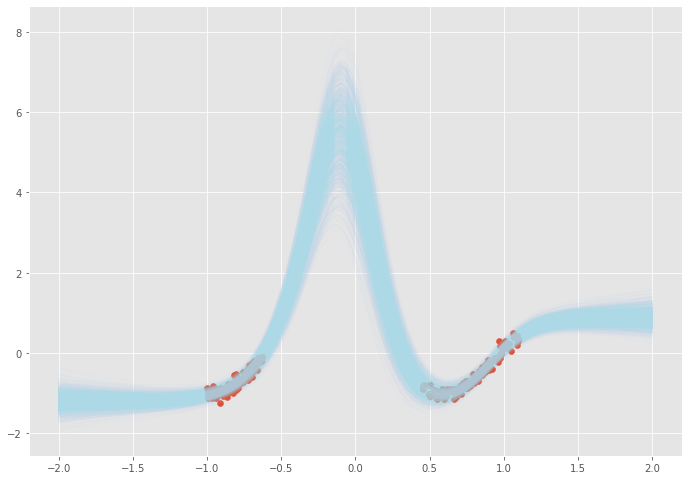

In [158]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    (L1_weight_epsilon, L1_bias_epsilon) = model.linear1.generate_rand()
    (L1_weight_sample, L1_bias_sample) = model.linear1.reparameterization()
    
    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')